# Семинар 4. Мультимодальные модели: captioning, VQA, ITM, cross-modal fusion.



BLIP-2 (Bootstrapping Language-Image Pre-training) - это современная архитектура, которая позволяет эффективно связывать зрение и язык.

[Статья](https://proceedings.mlr.press/v202/li23q/li23q.pdf#:~:text=image%20encoders%20and%20frozen%20large,various%20vision%02language%20tasks%2C%20despite%20having)

Главная фишка здесь в том, что вместо обучения гигантской модели с нуля, BLIP-2 действует по такой схеме:

1.  Vision encoder (заморожен) выдает последовательность визуальных токенов `[B, N_patches, D_v]`.

2. Q-Former (bridge) через cross-attention вытягивает нужное и сжимает в фиксированное число query tokens `[B, N_query, D_q]`.

3. LLM (заморожена) получает эти сжатые мультимодальные токены и генерирует текст.

Q-Former вытягивает из картинки только те признаки, которые полезны для текста, и скармливает их языковой модели. По смыслу это обучаемый `pooling + projection`, что очень близко к идее нашего ДЗ2 (там вместо Q-Former вы делаете свой адаптер).

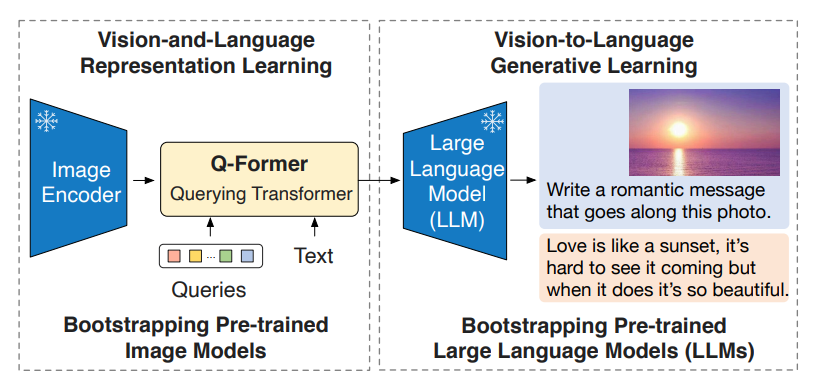

Напоминание, о чем мы общаемся на этой неделе:

* Early fusion - объединяем сырые/низкоуровневые признаки модальностей как можно раньше (обычно дорого и сложно).
* Late fusion - каждая модальность обрабатывается отдельно, а потом объединяем готовые признаки (часто проще, но слабее по взаимодействию).
* Joint fusion / Joint encoder - модель учится делать взаимодействие модальностей внутри трансформера (через cross-attention/self-attention).

Тогда почему мы разбираем сейчас BLIP-2?

* Vision encoder извлекает визуальные токены - это унимодальная часть.
* Q-Former делает cross-modal attention: query-токены получают информацию из визуальных токенов -> это и есть механизм **fusion**.
* Затем идёт проекция в пространство LLM и генерация -> это доведение мультимодальной информации до языка.

В этом семинаре мы рассмотрим две практические части:

1. BLIP-2 Inference (без обучения): image captioning, VQA и извлечение признаков (эмбеддингов) + разбор, где именно находится fusion через Q-Former.
2. Fine-tuning BLIP-2 под VQA: дообучение модели с LoRA (на A100 или нет) и задание на сравнение настроек (target_modules, r, prompt-template) и анализ влияния на loss и Exact Match.


## Инференс BLIP-2

Для работы с BLIP-2 нам понадобится библиотека `transformers` версии 4.26+ и `accelerate` для оптимального распределения весов.

In [ ]:
import os

# Xet - механизм скачивания больших файлов с Hub.
# high performance mode заметно помогает на больших чекпоинтах.
os.environ["HF_XET_HIGH_PERFORMANCE"] = "1" # ускорение

# иногда полезно увеличить таймауты
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "600"
os.environ["HF_HUB_ETAG_TIMEOUT"] = "60"

In [ ]:
!pip -q install -U transformers accelerate bitsandbytes huggingface_hub hf_xet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 143.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 36.3 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import snapshot_download

MODEL_NAME = "Salesforce/blip2-opt-2.7b"
LOCAL_DIR = "/content/models/blip2-opt-2.7b"

_ = snapshot_download(
    repo_id=MODEL_NAME,
    local_dir=LOCAL_DIR,
    local_dir_use_symlinks=False,
    resume_download=True,
)

print("Snapshot downloaded to:", LOCAL_DIR)

In [ ]:
import torch
from PIL import Image
import requests
from io import BytesIO

from transformers import (
    AutoProcessor,
    Blip2ForConditionalGeneration,
    Blip2Model,
    BitsAndBytesConfig,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)
print("torch:", torch.__version__)

device: cuda
torch: 2.9.0+cu126


**Загрузка данных**

Напишем вспомогательную функцию для загрузки картинок из интернета. Используем ту же картинку, что и в оригинальном демо (женщина с собакой на пляже), чтобы сравнить результаты.

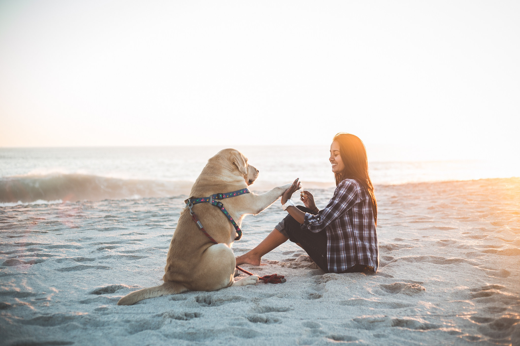

In [ ]:
from IPython.display import display

def load_image_from_url(url):
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

def show(img, max_side=520):
    w, h = img.size
    s = max_side / max(w, h)
    if s < 1:
        img = img.resize((int(w*s), int(h*s)))
    display(img)

# загружаем классическое тестовое изображение для BLIP
img_url = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"
image = load_image_from_url(img_url)
show(image)

### Image Captioning

Для этой задачи мы используем модель `blip2-opt-2.7b`. Это версия, где визуальные признаки передаются в языковую модель OPT (Open Pre-trained Transformer) от Meta.

  * Processor - занимается предобработкой картинки (ресайз, нормализация) и токенизацией текста.
  * Model - сама нейросеть `Blip2ForConditionalGeneration`.

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

# мы используем OPT-2.7B - это хороший баланс качества и веса для Colab
MODEL_NAME = "Salesforce/blip2-opt-2.7b"
# альтернатива для captioning - обученный на датасете coco:
# MODEL_NAME = "Salesforce/blip2-opt-2.7b-coco"

processor = AutoProcessor.from_pretrained(LOCAL_DIR)

# самый надежный режим для Colab: 4-bit quantization
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = Blip2ForConditionalGeneration.from_pretrained(
    LOCAL_DIR,
    quantization_config=bnb,
    device_map="auto",
    torch_dtype=torch.float16,
)

model.eval()
print("Loaded:", MODEL_NAME)
print("First param device:", next(model.parameters()).device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded: Salesforce/blip2-opt-2.7b
First param device: cuda:0


>*Кстати, почему мы сразу используем 4-bit?*
>
> Потому что Salesforce/blip2-opt-2.7b тяжёленькая. В 4-bit она обычно заводится на Colab T4 без боли.

#### Что делает processor

Blip2Processor - это image processor + tokenizer, который готовит входы ровно в том виде, в каком BLIP-2 ожидает их на инференсе/дообучении.

[Что делаем с картинкой](https://huggingface.co/Salesforce/blip2-opt-2.7b/blob/main/preprocessor_config.json )

Типичный CV-препроцессинг:

* Конвертация в RGB: `do_convert_rgb: true`.
* Resize до 224×224: `do_resize: true`, `size: {"height":224,"width":224}`.
* Rescale пикселей в `[0,1]`: `do_rescale: true`, `rescale_factor: 1/255 = 0.0039215686`.
* Normalize (вычитание среднего / деление на std) с параметрами:

  * `image_mean = [0.48145466, 0.4578275, 0.40821073]`
  * `image_std  = [0.26862954, 0.26130258, 0.27577711]`
* Возвращает тензор `pixel_values` формы примерно `[B, 3, 224, 224]`.

> Эти mean/std - CLIP-похожие константы; важно не менять их без причины, иначе качество может упасть.

[Что делаем с текстом](https://huggingface.co/Salesforce/blip2-opt-2.7b/blob/main/tokenizer_config.json )

Токенизируем текст:

* Используется `GPT2Tokenizer` (т.к. текстовая часть — OPT): `tokenizer_class: "GPT2Tokenizer"`.
* Добавляет BOS: `add_bos_token: true`.
* Спец-токены:

  * `"<pad>"`, `"</s>"` (и они же заданы как `bos_token/eos_token`)
  * есть спец-токен `"<image>"` с id 50265 - это якорь для мультимодальности в конфиге модели (`image_token_index: 50265`).
* На выходе обычно появляются `input_ids` и `attention_mask` (+ `pixel_values`).


In [ ]:
# image-side
print(type(processor.image_processor))
print("size:", processor.image_processor.size)
print("mean:", processor.image_processor.image_mean)
print("std :", processor.image_processor.image_std)

# text-side
print(type(processor.tokenizer))
print("bos:", processor.tokenizer.bos_token, "eos:", processor.tokenizer.eos_token, "pad:", processor.tokenizer.pad_token)
print("image token id:", processor.tokenizer.convert_tokens_to_ids("<image>"))

<class 'transformers.models.blip.image_processing_blip.BlipImageProcessor'>
size: {'height': 224, 'width': 224}
mean: [0.48145466, 0.4578275, 0.40821073]
std : [0.26862954, 0.26130258, 0.27577711]
<class 'transformers.models.gpt2.tokenization_gpt2_fast.GPT2TokenizerFast'>
bos: </s> eos: </s> pad: <pad>
image token id: 50265


#### Поехали дальше

Теперь запустим генерацию описания. В отличие от старого BLIP, здесь мы не используем специальный токен "caption:", модель способна понять задачу из контекста или вообще без промпта (unconditional generation).

In [ ]:
# для простого описания текст подавать не обязательно, только картинку
inputs = processor(images=image, return_tensors="pt").to(model.device)

with torch.no_grad():
    out_ids = model.generate(
        **inputs,
        max_new_tokens=30,
        num_beams=3, # beam search
    )

caption = processor.batch_decode(out_ids, skip_special_tokens=True)[0].strip()
caption

'a woman sitting on the beach with her dog'

> Покрутим `num_beams` (1, 3, 5) и `max_new_tokens`. Что меняется?

#### `num_beams` и `max_new_tokens`

**num_beams**

Это ширина beam search: сколько гипотез модель держит параллельно на каждом шаге генерации.

* `num_beams=1` -> beam search выключен (дальше уже либо greedy, либо sampling - зависит от `do_sample`).
* Чем больше `num_beams`, тем лучше качество/правдоподобие (модель меньше жадничает на ранних шагах), но тем медленнее и прожорливее по вычислениям.
* Для beam search часто включают `early_stopping=True`, чтобы закончить, когда набралось достаточно завершённых (EOS) гипотез.

> Практически для caption/VQA: `num_beams=3..5` - хороший старт; `1` - быстрее, но иногда хуже формулировки.

**max_new_tokens**

Это лимит на число новых токенов, которые модель может дописать поверх промпта, не считая вход (prompt).

* Если модель раньше сгенерит EOS - она остановится раньше лимита.
* `max_new_tokens` переопределяет эффект `max_length`, который считается как `len(prompt)+max_new_tokens`.
* В гайде HF отмечают, что по умолчанию генерация часто ограничивается небольшим числом токенов (например, 20), поэтому `max_new_tokens` обычно задают явно, особенно для LLM.

> Практически:
>
>* caption: `max_new_tokens=20..40`
> * VQA (короткий ответ): `max_new_tokens=5..15`


#### Поехали дальше

Теперь поуправляем стилем.

In [ ]:
prompt = "Describe the image in one short sentence:"
inputs = processor(images=image, text=prompt, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

out_ids = model.generate(**inputs, max_new_tokens=30, num_beams=3)

prompt_len = inputs["input_ids"].shape[1]
gen_ids = out_ids[0, prompt_len:]
caption = processor.tokenizer.decode(gen_ids, skip_special_tokens=True).strip()
caption

'A woman and her dog are sitting on the beach at sunset'

> Тут можно поиграть с промптами.

### Visual Question Answering (VQA)

BLIP-2 очень силен в визуальных вопросах. Нам не нужно менять модель или загружать чекпоинт `vqa`. Та же самая модель (Generative) может отвечать на вопросы, если мы правильно оформим промпт.

Формат промпта для BLIP-2 (OPT версии):
`Question: {ваш вопрос} Answer:`

In [ ]:
import re

def blip2_vqa(img: Image.Image, question: str, max_new_tokens=20, num_beams=3):
    q = question.strip()
    q = re.sub(r'^\s*Question:\s*', '', q, flags=re.I)
    q = re.sub(r'\s*Answer:\s*$', '', q, flags=re.I)

    prompt = f"Question: {q} Answer:"
    inputs = processor(images=img, text=prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        out_ids = model.generate(**inputs, max_new_tokens=max_new_tokens, num_beams=num_beams)

    if not model.language_model.config.is_encoder_decoder:
        in_len = inputs["input_ids"].shape[-1]
        out_ids = out_ids[:, in_len:]

    answer = processor.tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0].strip()
    return answer

In [ ]:
# зададим вопрос модели
question = "where is the woman sitting?"

print("Question:", question)
print("Answer:", blip2_vqa(image, question))

Question: where is the woman sitting?
Answer: on the beach with her dog


In [ ]:
# давайте попробуем спросить что-то сложнее
question2 = "Question: What is the dog doing? Answer:"

print("Question:", question2)
print("Answer:", blip2_vqa(image, question2))

Question: Question: What is the dog doing? Answer:
Answer: Playing with the girl


**Задание**

Сформулируйте вопрос-ловушку (grounding-проверку), на который модель вероятно ошибtтся:

- спросить про объект, которого нет
- спросить что написано на табличке
- спросить какой бренд на одежде

### Что здесь Fusion & Joint? Смотрим Q-Former внутри

**Feature Extraction (Извлечение признаков)**

Иногда нам не нужно генерировать текст, а нужно получить векторное представление (эмбеддинг) картинки и текста для задач поиска (Retrieval) или классификации.

В BLIP-2 за это отвечает **Q-Former**. Мы можем извлечь выходы Q-Former до того, как они попадут в LLM. Для этого используем класс `Blip2Model` (без "ForConditionalGeneration").

*Примечание: Чтобы не забивать память GPU второй моделью, в рамках этого семинара мы покажем, как извлечь скрытые состояния из уже загруженной модели.*


In [ ]:
# vision encoder (обычно ViT-подобный) выдает длинную последовательность патч-токенов

inputs_img = processor(images=image, return_tensors="pt").to(model.device)
pixel_values = inputs_img["pixel_values"]

with torch.no_grad():
    vision_out = model.vision_model(pixel_values=pixel_values, return_dict=True)
    image_embeds = vision_out.last_hidden_state  # [B, N_patches, D_v]

print("image_embeds shape:", tuple(image_embeds.shape))

image_embeds shape: (1, 257, 1408)


В `Blip2ForConditionalGeneration` энкодером является Q-Former. Мы можем обратиться к нему через `model.qformer`.


**Q-Former как learnable pooling: query tokens → cross-attend на image_embeds**

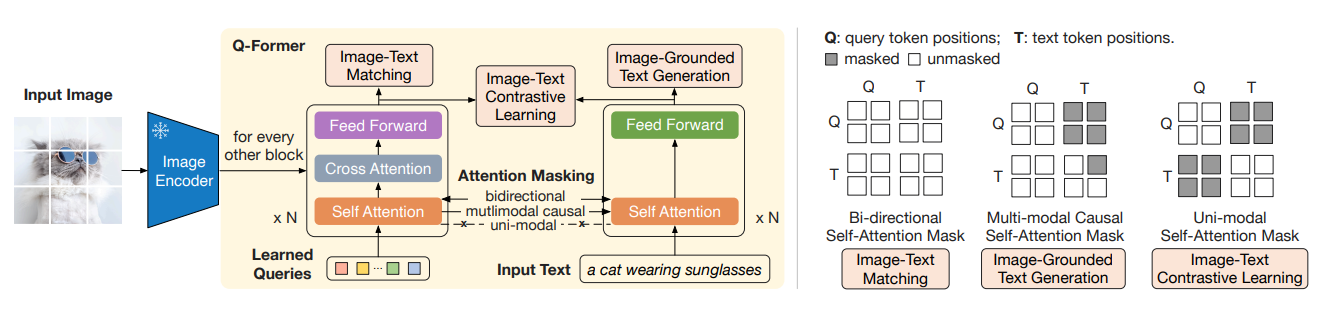

#### Рисунок про Q-Former masks и цели обучения (ITM / ITC / ITG)

На рисунке у нас есть:

* Q - позиции query tokens (обучаемые запросы Q-Former),
* T - позиции text tokens (токены текста).

И разные маски self-attention внутри Q-Former, которые включаются в зависимости от задачи:

**ITM - Image-Text Matching**

Здесь бинарная задача: подходит ли этот текст к этой картинке?
Маска: Bidirectional self-attention между Q и T (как в BERT). Query-токены и текстовые токены могут свободно смотреть друг на друга. Зачем? Чтобы модель могла глубоко сопоставлять описание и изображение.

> Это такой классический joint encoder: совместная обработка (Q+T) внутри одного трансформера.

**ITG - Image-Grounded Text Generation**

Генерация текста, заземлённая в изображение (captioning, VQA в формате генерации). Маска - Multimodal causal mask:

* текстовые токены должны быть каузальными (каждый токен видит только прошлые токены),
* но при этом имеют доступ к визуальной информации через query tokens / cross-attention.
Накой? Чтобы генерация была авто-регрессионной, как у языковой модели.

>  fusion здесь в том, что текст подсасывает из изображения через мостик (query tokens) во время генерации.

**ITC - Image-Text Contrastive (CLIP-style)**

Контрастивное обучение - приблизить эмбеддинги текста и картинки для похожих пар и отдалить для непохожих. Маска? Unimodal mask - по сути отдельно видим только своё:

* query-токены формируют image-репрезентацию,
* текстовые токены формируют text-репрезентацию,
* дальше сравнение через контрастивный лосс.

Таким образом получаем хорошие эмбеддинги для retrieval/поиска.

> Это уже ближе к late fusion на уровне представлений (взаимодействие не внутри токенов, а через контрастивный objective).



#### Поехали дальше

> В BLIP-2 Q-Former делает две ключевые операции, которые вы и хотите от адаптера в ДЗ2:
>
> 1. Сжатие последовательности визуальных токенов (их много) в небольшое число query-токенов (их мало).
> 2. Проекция в пространство LLM, чтобы LLM могла прочитать мультимодальную информацию.
>
> Именно поэтому мы в семинаре смотрим BLIP-2 как пример.

Мы напрямую маски Q-Former не переключаем в лоб одной строчкой (в `transformers` это завязано на режим/конфиг), но зато можем глянуть, что Q-Former способен работать и:

* только с query tokens (image-only),
* и с query + text (совместно, как joint encoder входа).

Ключевая идея: мы не делаем mean pooling по патчам.
Мы вводим N_query обучаемых токенов, которые вытягивают из картинки нужное через cross-attention.

In [ ]:
B = image_embeds.shape[0]

# маска для виз токенов: все валидны
image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=model.device)

# query tokens (обучаемые параметры Q-Former)
query_tokens = model.query_tokens.expand(B, -1, -1) # [B, N_query, D_q]
n_q = query_tokens.shape[1]
print("N_query:", n_q)

with torch.no_grad():
    q_out = model.qformer(
        query_embeds=query_tokens,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_attention_mask,
        return_dict=True,
    )

q_feats = q_out.last_hidden_state  # [B, N_query, D_q]
print("qformer query features:", tuple(q_feats.shape))

N_query: 32
qformer query features: (1, 32, 768)


> * `image_embeds`: много визуальных токенов (patch grid)
> * `q_feats`: фиксированное число токенов после fusion (сжатое мультимодальное представление)
>
> Это и есть joint encoder/bridge: он собирает из зрения то, что нужно для языка.

**Q-Former, conditioned на текст: картинка + подпись → более совместные признаки**

Если передать текст, то Q-Former выдаёт последовательность, где первые `N_query` позиций - query-токены, а дальше идут текстовые токены. Поэтому мы аккуратно выделяем именно query-часть.

In [ ]:
text_prompt = "a woman sitting on the beach with a dog"

# токены языковой модели (OPT/T5)
inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(model.device)

pixel_values = inputs["pixel_values"]
input_ids    = inputs["input_ids"]
attn_text    = inputs["attention_mask"]

with torch.no_grad():
    # Vision encoder - визуальные токены
    vision_out = model.vision_model(pixel_values=pixel_values, return_dict=True)
    image_embeds = vision_out.last_hidden_state # [B, Sv, Dv]
    image_attn   = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=model.device)

    # Q-Former: query tokens (32) + cross-attn к image_embeds
    qt = model.query_tokens.expand(image_embeds.size(0), -1, -1) # [B, Nq=32, Dq]
    q_out = model.qformer(
        query_embeds=qt,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_attn,
        return_dict=True
    ).last_hidden_state# [B, 32, Dq]

    # проекция Q-Former -> hidden space LLM (OPT/T5)
    q_llm = model.language_projection(q_out) # [B, 32, H]

    # embeddings текста из LLM embedding layer
    tok_emb = model.language_model.get_input_embeddings()(input_ids) # [B, T, H]

    # вот где joint: склеиваем 32 визуальных токена + T текстовых
    joint_embeds = torch.cat([q_llm, tok_emb], dim=1) # [B, 32+T, H]
    joint_attn   = torch.cat(
        [torch.ones((input_ids.size(0), q_llm.size(1)), dtype=attn_text.dtype, device=model.device),
         attn_text],
        dim=1
    )  # [B, 32+T]

print("q_out (Q-Former) shape:", tuple(q_out.shape))# [B, 32, Dq]
print("tok_emb (LLM text) shape:", tuple(tok_emb.shape)) # [B, T, H]
print("joint_embeds shape:", tuple(joint_embeds.shape)) # [B, 32+T, H]
print("joint_attn shape:", tuple(joint_attn.shape)) # [B, 32+T]

q_out (Q-Former) shape: (1, 32, 768)
tok_emb (LLM text) shape: (1, 42, 2560)
joint_embeds shape: (1, 74, 2560)
joint_attn shape: (1, 74)


Projection в пространство LLM (ещё один adapter layer).

Чтобы эти query-features попали в LLM, BLIP-2 делает `language_projection`: `D_q → D_llm`.

In [ ]:
with torch.no_grad():
    llm_inputs = model.language_projection(q_feats) # [B, N_query, D_llm]
print("projected to LLM hidden:", tuple(llm_inputs.shape))

projected to LLM hidden: (1, 32, 2560)


> Ваш адаптер в ДЗ2 должен делать похожее: сжать последовательность (время/пространство) и спроецировать в hidden size Qwen.

Теперь маленький эксперимент: возьмем эмбеддинг картинки из query tokens. Это не retrieval-метод как в CLIP, но демонстрирует идею компактного вектора картинки.

In [ ]:
import torch.nn.functional as F

def get_qformer_image_embedding(img: Image.Image):
    inputs = processor(images=img, return_tensors="pt").to(model.device)
    with torch.no_grad():
        v = model.vision_model(pixel_values=inputs["pixel_values"], return_dict=True).last_hidden_state
        attn = torch.ones(v.size()[:-1], dtype=torch.long, device=model.device)
        qt = model.query_tokens.expand(v.shape[0], -1, -1)
        q = model.qformer(query_embeds=qt, encoder_hidden_states=v, encoder_attention_mask=attn, return_dict=True).last_hidden_state
        emb = F.normalize(q.mean(dim=1), dim=-1)  # mean по query
    return emb

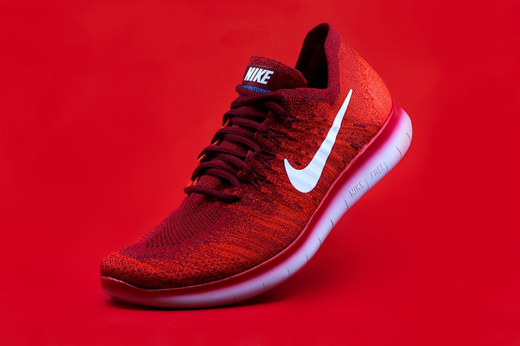

cosine similarity: 0.2721548080444336


In [ ]:
img2 = load_image_from_url("https://images.unsplash.com/photo-1542291026-7eec264c27ff?auto=format&fit=crop&w=900&q=60")
show(img2)

e1 = get_qformer_image_embedding(image)
e2 = get_qformer_image_embedding(img2)
sim = (e1 @ e2.T).item()
print("cosine similarity:", sim)

**Image-Text Matching (ITM)**

В оригинальном BLIP была отдельная голова для ITM (бинарная классификация: подходит текст к картинке или нет).
В BLIP-2 такая функциональность тоже есть, но она обычно используется при претрейне.
В библиотеке `transformers` для генеративных моделей (как та, что мы загрузили `Salesforce/blip2-opt-2.7b`) метод `forward` заточен на вычисление Loss для генерации языка (`CausalLMOutput`).

Однако мы можем эмулировать Matching через вычисление [Perplexity](https://education.yandex.ru/handbook/math/article/entropiia-perpleksiia-kl-divergentsiia#:~:text=%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D0%BE%D0%B9%20%E2%80%94%20%D0%BF%D0%B5%D1%80%D0%BF%D0%BB%D0%B5%D0%BA%D1%81%D0%B8%D0%B5%D0%B9.-,%D0%9F%D0%B5%D1%80%D0%BF%D0%BB%D0%B5%D0%BA%D1%81%D0%B8%D1%8F,-%D0%9A%D0%B0%D0%BA%20%D0%BC%D1%8B%20%D0%B2%D0%B8%D0%B4%D0%B5%D0%BB%D0%B8) (PPL) или вероятности генерации этого текста. Если модель при виде картинки приписывает тексту высокую вероятность - значит, они подходят.


In [ ]:
def nll_match_score(image, text):
    """
    Эвристика matching через средний NLL (loss) генерации.
    Меньше loss -> текст более совместим с картинкой.
    """
    inputs = processor(images=image, text=text, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        out = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask", None),
            pixel_values=inputs["pixel_values"],
            labels=inputs["input_ids"],  # teacher forcing
        )
    return float(out.loss)

# чтобы получить ppl отсюда
# надо взять экспоненту:
# ppl = exp(out.loss.item())

text_match = "a woman sitting on the beach with a dog"
text_mismatch = "a red car driving on the street"

s1 = nll_match_score(image, text_match)
s2 = nll_match_score(image, text_mismatch)

print("NLL(match)   :", s1)
print("NLL(mismatch):", s2)
print("lower is better")

NLL(match)   : 12.3515625
NLL(mismatch): 13.5703125
lower is better


Если `out.loss` - это средняя кросс-энтропия в натах (это единицы информации), то отношение правдоподобий (в среднем на токен) примерно:

$$\frac{p(\text{text}|\text{image})*\text{match}}{p(\text{text}|\text{image})*\text{mismatch}} \approx e^{\Delta} = e^{1.21875} \approx 3.4$$




> дельта 1.21875, это 3.4 раза более вероятным (на токен)

#### teacher forcing

Мобучаем, подавая правильный ответ как контекст:
`labels=inputs["input_ids"]`:

* input_ids подаются и как вход (модель видит всю последовательность текста).
* те же input_ids подаются как labels - то, что модель должна воспроизвести.

Дальше внутри `CausalLM` происходит следующее:

1. Модель берёт input_ids и считает logits для всех позиций.
2. Сдвигает их на один шаг (предсказываем токен `t_i` из контекста `t_0..t_{i-1}`).
3. Считает кросс-энтропию между предсказанным распределением и реальным токеном в каждой позиции.
4. Усредняет по токенам → получается out.loss = средний NLL на токен.

То есть teacher forcing - это "мы не генерируем по одному токену автоподстановкой, а сразу подаем всю правильную последовательность и считаем ошибку предсказания каждого токена".


#### Поехали дальше

**Задание для самостоятельной работы**

Попробуйте загрузить свою картинку и заставить BLIP-2 описать её в стиле:

1.  Обычного описания
2.  Ответа на вопрос "What style is this image?"
3.  Попробуйте обмануть модель, спросив о предмете, которого нет на фото

## Дообучение BLIP-2 под VQA

Идея раздела: мы не обучаем BLIP-2 целиком, а делаем parameter-efficient fine-tuning: LoRA на языковой части (Flan-T5), при этом vision encoder и Q-Former остаются как есть.

In [ ]:
import os

os.environ["HF_XET_HIGH_PERFORMANCE"] = "1"
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "600"
os.environ["HF_HUB_ETAG_TIMEOUT"] = "60"

In [ ]:
!pip -q install "pillow==10.4.0"

In [ ]:
!pip -q install -U "transformers>=4.46" accelerate peft datasets evaluate
!pip -q install -U bitsandbytes

In [ ]:
import os
import ast
import random
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import display
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import (
    AutoProcessor,
    Blip2ForConditionalGeneration,
    BitsAndBytesConfig,
    get_linear_schedule_with_warmup,
)

from peft import LoraConfig, get_peft_model, TaskType

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

torch.backends.cuda.matmul.allow_tf32 = True # TF32 ускоряет матмулы
torch.backends.cudnn.allow_tf32 = True # и почти не портит качество в обучении

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device: cuda


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [ ]:
!wget  -O 'images-with-vqas.zip' -q 'https://www.dropbox.com/scl/fi/sulhcls13hpf0guht6dzk/images-with-vqas.zip?rlkey=mjjfcmrz0vci11jpi098k6s9t&st=ccss1bc3&dl=0'

In [ ]:
# распаковываем архив
!mkdir -p /content/images-with-vqas
!unzip -q -o images-with-vqas.zip -d /content/images-with-vqas

# посмотрим структуру
!ls -lah /content/images-with-vqas | head

total 541M
drwxr-xr-x 3 root root 4.0K Dec  3 08:59 .
drwxr-xr-x 1 root root 4.0K Dec  3 08:59 ..
drwxr-xr-x 3 root root 4.0K Dec  3 08:59 final_dataset
-rw-r--r-- 1 root root 136M May 16  2025 merged_image_data_vqa.csv
-rw-r--r-- 1 root root  27M May 16  2025 test_20.csv
-rw-r--r-- 1 root root  27M May 16  2025 test_20_withoutyesno.csv
-rw-r--r-- 1 root root  69M May 16  2025 test.csv
-rw-r--r-- 1 root root 109M May 16  2025 train_80.csv
-rw-r--r-- 1 root root 108M May 16  2025 train_80_withoutyesno.csv


In [ ]:
CSV_PATH = "/content/images-with-vqas/merged_image_data_vqa.csv"
IMG_PREFIX_OLD = r"^Dataset/final_dataset/"
IMG_PREFIX_NEW = "/content/images-with-vqas/final_dataset/final_dataset/"

NROWS = 2000

df = pd.read_csv(CSV_PATH, nrows=NROWS)
df["image_path"] = df["image_path"].str.replace(IMG_PREFIX_OLD, IMG_PREFIX_NEW, regex=True)

# vqa_response записан как строка со списком пар {"question":...,"answer":...} или [("q","a"), ...]
# в датасете nathanmathew это часто list объектов - парсим literal_eval
df["vqa_response"] = df["vqa_response"].apply(ast.literal_eval)

# взрываем список Q/A в отдельные строки :)
df = df.explode("vqa_response").reset_index(drop=True)

# превращаем в две колонки: question/answer
qa = pd.DataFrame(df["vqa_response"].tolist(), columns=["question", "answer"])
df = pd.concat([df.drop(columns=["vqa_response"]), qa], axis=1)

# чекаем, что пути к картинкам существуют
exists = df["image_path"].apply(os.path.exists)
print(f"Пропускаем {(~exists).sum()} строк с отсутствующими изображениями")
df = df[exists].reset_index(drop=True)

df = df[["image_path", "question", "answer"]]
print("Итого примеров:", len(df))
df.head(3)

Пропускаем 0 строк с отсутствующими изображениями
Итого примеров: 5973


,image_path,question,answer
0,/content/images-with-vqas/final_dataset/final_...,What is the main color of the shoe?,Brown
1,/content/images-with-vqas/final_dataset/final_...,What is the pattern on the shoe?,Snakeskin
2,/content/images-with-vqas/final_dataset/final_...,Does the shoe have a tassel?,Yes


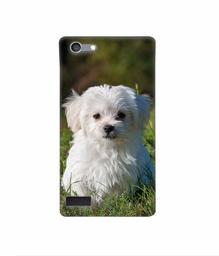

Q : What color is the puppy?
A : White
----------------------------------------------------------------------


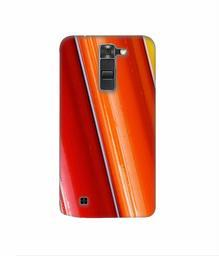

Q : Is the phone case design symmetrical?
A : No
----------------------------------------------------------------------


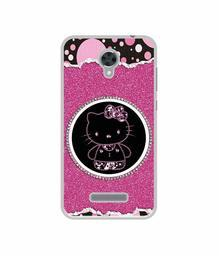

Q : What color is the main background of the phone case?
A : Pink
----------------------------------------------------------------------


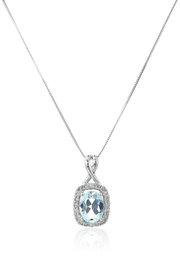

Q : What is the shape of the gemstone?
A : Oval
----------------------------------------------------------------------


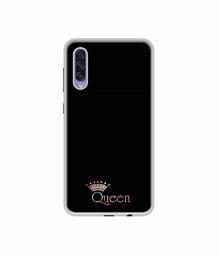

Q : What shape is the phone case?
A : Rectangle
----------------------------------------------------------------------


In [ ]:
show_n = 5
sample = df.sample(min(show_n, len(df)), random_state=42)

for row in sample.itertuples():
    img = Image.open(row.image_path).convert("RGB")
    w, h = img.size
    display(img.resize((min(380, w), int(h * min(380, w) / w))))
    print("Q :", row.question)
    print("A :", row.answer)
    print("-" * 70)

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=SEED)
print("train:", len(train_df), "val:", len(val_df))

train: 5375 val: 598


### Processor + модель BLIP-2 (Flan-T5)

Мы берём: `Salesforce/blip2-flan-t5-xl`.

> `processor` делает и препроцессинг картинок, и токенизацию текста - это мы уже посмотрели.
>
> На A100 предпочтительнее **bfloat16**, поэтому мы грузим модель в BF16.

Если OOM - включаем `USE_8BIT=True`.

In [ ]:
MODEL_NAME = "Salesforce/blip2-flan-t5-xl"

USE_8BIT = False  # если вылетает по памяти - поставим True
USE_GRAD_CHECKPOINTING = False  # можно True, если памяти мало

processor = AutoProcessor.from_pretrained(MODEL_NAME)

if USE_8BIT:
    # 8-bit загрузка экономит память (T4), на A100 чаще не нужно
    bnb_config = BitsAndBytesConfig(load_in_8bit=True)
    model = Blip2ForConditionalGeneration.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        quantization_config=bnb_config,
    )
else:
    # BF16 - если работаем с A100
    model = Blip2ForConditionalGeneration.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map="auto",
    )

if USE_GRAD_CHECKPOINTING:
    # экономит память, но замедляет обучение
    model.gradient_checkpointing_enable()
    # иногда полезно вместе с этим отключить кэш
    if hasattr(model, "config"):
        model.config.use_cache = False

model.eval()

print("Загружено:", MODEL_NAME)
print("Первый параметр на устройстве:", next(model.parameters()).device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/5.81G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Загружено: Salesforce/blip2-flan-t5-xl
Первый параметр на устройстве: cuda:0


### Датасет и collate_fn

Ключевой момент: паддинг делаем динамически внутри collate_fn (`padding=True`), а не в max_length всегда.

> * `input_ids/attention_mask` - это токены вопроса (prompt).
> * `labels` - это токены ответа; паддинги в `labels` заменяем на `-100`, чтобы по ним не считался лосс.

In [ ]:
class VQADataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # картинки читаем в RGB
        image = Image.open(row.image_path).convert("RGB")
        return {
            "image": image,
            "question": str(row.question),
            "answer": str(row.answer),
        }

# промпт. Можно менять формат, но важно использовать ОДИН и тот же формат везде.
def make_prompt(q: str) -> str:
    return f"Question: {q} Answer:"

MAX_Q_LEN = 64 # максимум токенов для вопроса
MAX_A_LEN = 16 # ответы обычно короткие, ограничим

def collate_fn(batch):
    # batch: список словарей {image, question, answer}
    images = [x["image"] for x in batch]
    prompts = [make_prompt(x["question"]) for x in batch]
    answers = [x["answer"] for x in batch]

    # кодируем картинку + текст
    enc = processor(
        images=images,
        text=prompts,
        return_tensors="pt",
        padding=True, # динамический padding по батчу
        truncation=True,
        max_length=MAX_Q_LEN,
    )

    # токенизируем ответы отдельно - labels
    lab = processor.tokenizer(
        answers,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=MAX_A_LEN,
    )["input_ids"]

    # labels игнорируем pad-токены - иначе модель учится предсказывать паддинг
    lab[lab == processor.tokenizer.pad_token_id] = -100

    enc["labels"] = lab
    return enc

In [ ]:
train_ds = VQADataset(train_df)
val_ds   = VQADataset(val_df)

# на A100 можно смело поднять batch_size
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    collate_fn=collate_fn,
)

**Санити-чек батча**

In [ ]:
batch = next(iter(train_loader))
for k, v in batch.items():
    print(k, tuple(v.shape), v.dtype)

input_ids (32, 49) torch.int64
attention_mask (32, 49) torch.int64
pixel_values (32, 3, 224, 224) torch.float32
labels (32, 4) torch.int64


### LoRA

В отличие от полного fine-tuning, LoRA добавляет маленькие матрицы (низкоранговые) в ключевые линейные слои attention, и учим только их.

Для Flan-T5 обычно хорошо работает LoRA на проекциях внимания: **q и v**.

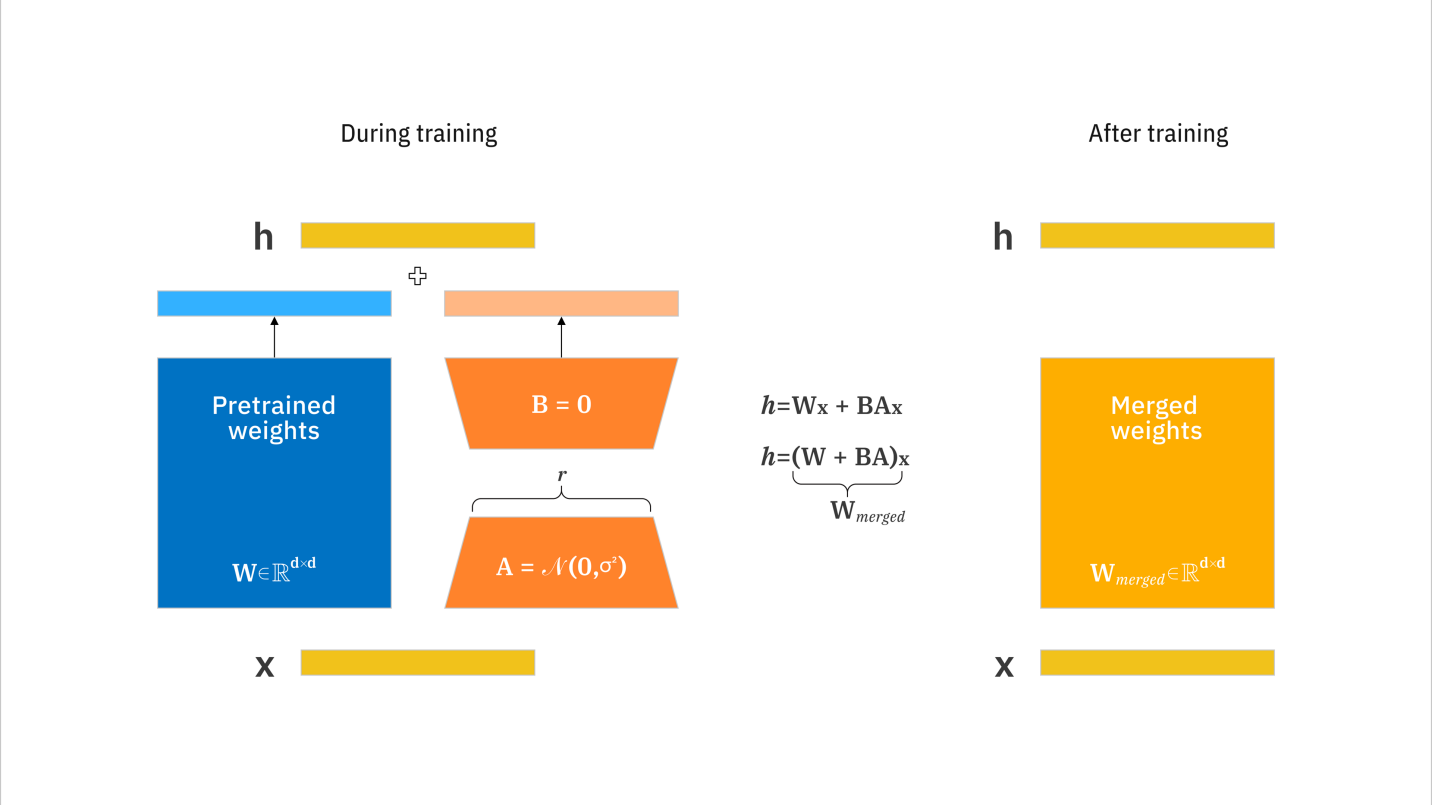

In [ ]:
# LORA конфиг:
# r - ранг (чем больше, тем больше параметров)
# alpha - множитель (часто 16–32)
# target_modules - какие имена модулей ловим внутри модели
# task_type - для Flan-T5 это seq2seq

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q", "v"], # для T5-архитектуры это типичный выбор
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# переводим в train-режим только перед обучением, сейчас можно оставить eval

trainable params: 4,718,592 || all params: 3,947,165,184 || trainable%: 0.1195


### Обучение (BF16 autocast + grad clipping + scheduler)

> * Мы оптимизируем только LoRA-параметры.
> * Лосс считается как cross-entropy по `labels` (ответам), т.к. модель учится генерировать ответ на вопрос по картинке.

In [ ]:
LR = 2e-4
EPOCHS = 3
GRAD_ACCUM_STEPS = 1 # можно увеличить, если хотите эффективный больший batch
MAX_GRAD_NORM = 1.0
WARMUP_RATIO = 0.05

# оптимизатор только по trainable параметрам (это важный момент!)
optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=LR
)

total_steps = (len(train_loader) // GRAD_ACCUM_STEPS) * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

scaler = torch.cuda.amp.GradScaler(enabled=False)  # на BF16 scaler не нужен
print("total_steps:", total_steps, "warmup_steps:", warmup_steps)

total_steps: 504 warmup_steps: 25


/tmp/ipython-input-1157338807.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=False)  # на BF16 scaler не нужен


In [ ]:
def move_to_device(batch, device):
    return {k: v.to(device) for k, v in batch.items()}

@torch.no_grad()
def evaluate_loss(model, val_loader):
    model.eval()
    total = 0.0
    n = 0
    for batch in tqdm(val_loader, desc="Валидация (loss)", leave=False):
        batch = move_to_device(batch, model.device)

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16,
                            enabled=(device == "cuda" and not USE_8BIT)):
            out = model(**batch)
            loss = out.loss

        bs = batch["input_ids"].size(0)
        total += loss.detach().item() * bs   # <-- FIX
        n += bs

    return total / max(1, n)

def train_one_epoch(model, train_loader):
    model.train()
    total = 0.0
    n = 0

    optimizer.zero_grad(set_to_none=True)

    for step, batch in enumerate(tqdm(train_loader, desc="Обучение", leave=False)):
        batch = move_to_device(batch, model.device)

        with torch.autocast(device_type="cuda", dtype=torch.bfloat16,
                            enabled=(device == "cuda" and not USE_8BIT)):
            out = model(**batch)
            loss = out.loss / GRAD_ACCUM_STEPS

        loss.backward()

        if (step + 1) % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad(set_to_none=True)

        bs = batch["input_ids"].size(0)
        total += loss.detach().item() * bs * GRAD_ACCUM_STEPS
        n += bs

    return total / max(1, n)

### Запуск обучения + сохранение лучшего LoRA-чекпоинта

In [ ]:
OUTPUT_DIR = "./blip2_vqa_lora"
os.makedirs(OUTPUT_DIR, exist_ok=True)

best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader)
    val_loss = evaluate_loss(model, val_loader)

    print(f"[Epoch {epoch}/{EPOCHS}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    # сохраняем только адаптер (PEFT), это быстро и компактно
    if val_loss < best_val:
        best_val = val_loss
        model.save_pretrained(os.path.join(OUTPUT_DIR, "best_adapter"))
        print("Хлабысь - сохранили лучший LoRA-адаптер:", os.path.join(OUTPUT_DIR, "best_adapter"))

[Epoch 1/3] train_loss=0.4916 | val_loss=0.4170
Хлабысь - сохранили лучший LoRA-адаптер: ./blip2_vqa_lora/best_adapter


[Epoch 2/3] train_loss=0.4616 | val_loss=0.4153
Хлабысь - сохранили лучший LoRA-адаптер: ./blip2_vqa_lora/best_adapter


[Epoch 3/3] train_loss=0.4549 | val_loss=0.4153


### Инференс

Генерация - это отдельный режим. Даже если loss падает, ответы могут быть странными при маленьком датасете/нехватке эпох.

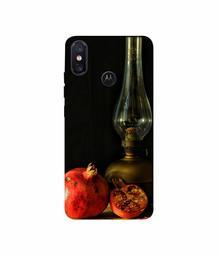

Q : What color is the pomegranate?
GT: Red
PR: Red


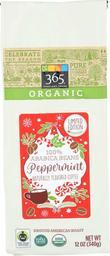

Q : What is the main flavor of the coffee?
GT: Peppermint
PR: Peppermint


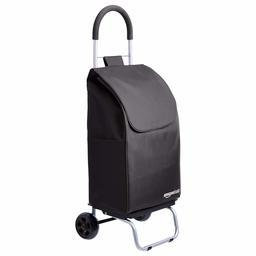

Q : What shape is the main carrying section?
GT: Rectangular
PR: Rectangular


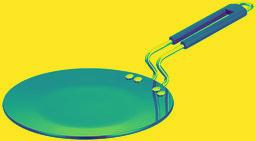

Q : What material appears to be used for the handle?
GT: Metal
PR: Metal


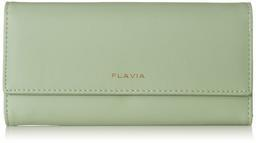

Q : What is the apparent material of the wallet?
GT: Leather
PR: Leather


In [ ]:
@torch.no_grad()
def generate_answer(model, image: Image.Image, question: str, max_new_tokens=10, num_beams=3):
    """
    Генерация ответа для BLIP-2.
    Важно: model.eval() + no_grad() - быстрее и без градиентов.
    """
    model.eval()

    prompt = make_prompt(question)
    batch = processor(
        images=[image],
        text=[prompt],
        return_tensors="pt",
        padding=True
    ).to(model.device)

    out_ids = model.generate(
        **batch,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
    )
    return processor.tokenizer.batch_decode(out_ids, skip_special_tokens=True)[0].strip()

sample_val = val_df.sample(5, random_state=SEED)

for row in sample_val.itertuples():
    img = Image.open(row.image_path).convert("RGB")
    w, h = img.size
    display(img.resize((min(380, w), int(h * min(380, w) / w))))

    pred = generate_answer(model, img, row.question, max_new_tokens=10, num_beams=3)

    print("Q :", row.question)
    print("GT:", row.answer)
    print("PR:", pred)

Простая метрика exact match на маленьком подмножестве. exact match довольно строгая метрика (особенно для коротких ответов и разных формулировок). Но как sanity-check для нас сгодится.


In [ ]:
def normalize(s: str) -> str:
    return str(s).strip().lower()

@torch.no_grad()
def exact_match_on_subset(model, df_subset, max_items=200):
    df_subset = df_subset.sample(min(max_items, len(df_subset)), random_state=SEED)
    hits = 0
    for row in tqdm(df_subset.itertuples(), total=len(df_subset), desc="Exact match"):
        img = Image.open(row.image_path).convert("RGB")
        pred = generate_answer(model, img, row.question, max_new_tokens=10)
        hits += int(normalize(pred) == normalize(row.answer))
    return hits / max(1, len(df_subset))

em = exact_match_on_subset(model, val_df, max_items=200)
print("Exact match (subset):", em)

Exact match: 100%|██████████| 200/200 [00:53<00:00,  3.71it/s]

Exact match (subset): 0.73


### Мини задание вам

Давайте поменяем:

* `target_modules`
* `r`
* `prompt-template`

И сравним:

* val_loss
* exact match(на небольшом сэмпле)

*Зачем это вообще делать?*

Потому что LoRA - это компромисс между:

* количеством обучаемых параметров (влияет на способность подстроиться под задачу),
* риском переобучения,
* вычислительной стоимостью.

И потому что prompt-template влияет на то, как именно модель понимает задачу VQA (у генеративных моделей это критично).

Поэтому держите три варианта для экспериментов.

**Эксперимент A: target_modules**

- попробуйте разные цели LoRA:

1. `["q", "v"]` - базовый, часто хороший.
2. `["q", "k", "v"]` - больше гибкости (может улучшить, но параметров больше).
3. `["q", "k", "v", "o"]` - ещё больше (иногда избыточно).

> Названия модулей зависят от конкретной реализации T5.
> Если сборка ругается, распечатайте имена линейных слоёв и подберите корректно.

**Эксперимент B: rank r**

Попробуйте `r ∈ {4, 8, 16}`.

* `r=4` - мало параметров, может не хватить мощности.
* `r=16` - больше параметров, выше шанс улучшить качество, но выше риск переобучения.

**Эксперимент C: prompt-template**

Попробуйте разные форматы:

1. `Question: {q} Answer:`
2. `Answer the question based on the image. Question: {q} Answer:`
3. `You are a visual assistant. Question: {q} Short answer:`

> Промпт влияет на режим генерации (инструкция/контекст).

**Несколько вопросов вам**

1. Как изменились val_loss и exact_match, когда вы увеличили `r`? Почему так могло произойти?
2. Почему смена prompt-template иногда меняет качество сильнее, чем `r`?
3. Если val_loss улучшился, но exact_match ухудшился - что это может означать?